In [1]:
import pandas as pd
import numpy as np
import ast
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

/Users/harshith.nikhil/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
tf.config.set_visible_devices([], 'GPU')

In [3]:
data=pd.read_csv('perfumes_sample.csv')
data.head()

,Unnamed: 0,index,notes,designer,reviews,description,url,title,gender
0,0,79106,"['Strawberry', 'Red Apple', 'Red Currant', 'St...",the body shop perfumes and colognes,"[""This was my childhood favourite in the 90's....",Strawberry Perfume Oil by The Body Shop is a F...,https://www.fragrantica.com/perfume/The-Body-S...,Strawberry Perfume Oil The Body Shop for women,Women
1,1,83656,"['Basil', 'Neroli', 'Bergamot', 'Geranium', 'J...",masik collegiate fragrances perfumes and colognes,[],The University of Oklahoma Men by Masik Colleg...,https://www.fragrantica.com/perfume/Masik-Coll...,The University of Oklahoma Men Masik Collegiat...,Men
2,2,29388,"['Orange', 'Bergamot', 'Lemon', 'Wild Berries'...",bharara perfumes and colognes,['Maybe it needs a bit longer to macerate. But...,Bleu by Bharara is a Aromatic Spicy fragrance ...,https://www.fragrantica.com/perfume/Bharara/Bl...,Bleu Bharara for men,Men
3,3,66849,"['Apple', 'Bergamot', 'Lavender', 'Artemisia',...",antonio banderas perfumes and colognes,"['عطر جميل وأداء مُرضي', ""Amazing cheapie, the...",Power of Seduction by Antonio Banderas is a Ar...,https://www.fragrantica.com/perfume/Antonio-Ba...,Power of Seduction Antonio Banderas for men,Men
4,4,62388,"['Lemon Blossom', 'Rosemary', 'Thyme', 'Bergam...",lord milano perfumes and colognes,[],Blue Water by Lord Milano is a Citrus Aromatic...,https://www.fragrantica.com/perfume/Lord-Milan...,Blue Water Lord Milano for women and men,Unisex


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   9999 non-null   int64 
 1   index        9999 non-null   int64 
 2   notes        9999 non-null   object
 3   designer     9999 non-null   object
 4   reviews      9999 non-null   object
 5   description  9999 non-null   object
 6   url          9999 non-null   object
 7   title        9999 non-null   object
 8   gender       9999 non-null   object
dtypes: int64(2), object(7)
memory usage: 703.2+ KB


In [5]:
notes_data=pd.read_csv('Development/LLM_DATA/NOTES_COMPREHENSIVE.csv')
notes_data.head()

,Name,Correct_Name,Scientific_name,Other_names,Group,Odor_profile,Note Link,Note Image
0,Bergamot,Bergamot,Citrus bergamia,Bergamot Orange,CITRUS SMELLS,"citrusy, bitter & tart, elegant, light note w...",https://www.fragrantica.com/notes/Bergamot-75....,https://fimgs.net/mdimg/sastojci/m.75.jpg?1650...
1,Bigarade,Bigarade,Citrus aurantium;,NaN,CITRUS SMELLS,None,https://www.fragrantica.com/notes/Bigarade-108...,https://fimgs.net/mdimg/sastojci/m.1083.jpg?16...
2,Bitter Orange,Bitter Orange,Citrus bigaradia,"Seville Orange, Bigarade Orange, Sour Orange, ...",CITRUS SMELLS,"It is inedible tart citrus, known as ""bigarad...",https://www.fragrantica.com/notes/Bitter-Orang...,https://fimgs.net/mdimg/sastojci/m.79.jpg?1440...
3,Blood Orange,Blood Orange,Citrus sinensis,Orange Sanguine,CITRUS SMELLS,"It is a mutation of the sweet orange, very sw...",https://www.fragrantica.com/notes/Blood-Orange...,https://fimgs.net/mdimg/sastojci/m.286.jpg?144...
4,Buddha s hand,Buddha's hand,Citrus Medica Var. Sarcodactylis,fingered citron,CITRUS SMELLS,"citrus, lemon, fresh, sweet, green, woody and...",https://www.fragrantica.com/notes/Buddha-s-han...,https://fimgs.net/mdimg/sastojci/m.1589.jpg?17...


In [6]:
def parse_notes(notes_str):
    try:
        return ast.literal_eval(notes_str)
    except:
        return []
data['notes'] = data['notes'].apply(parse_notes)

In [7]:
data.head()

,Unnamed: 0,index,notes,designer,reviews,description,url,title,gender
0,0,79106,"[Strawberry, Red Apple, Red Currant, Strawberr...",the body shop perfumes and colognes,"[""This was my childhood favourite in the 90's....",Strawberry Perfume Oil by The Body Shop is a F...,https://www.fragrantica.com/perfume/The-Body-S...,Strawberry Perfume Oil The Body Shop for women,Women
1,1,83656,"[Basil, Neroli, Bergamot, Geranium, Jasmine, S...",masik collegiate fragrances perfumes and colognes,[],The University of Oklahoma Men by Masik Colleg...,https://www.fragrantica.com/perfume/Masik-Coll...,The University of Oklahoma Men Masik Collegiat...,Men
2,2,29388,"[Orange, Bergamot, Lemon, Wild Berries, White ...",bharara perfumes and colognes,['Maybe it needs a bit longer to macerate. But...,Bleu by Bharara is a Aromatic Spicy fragrance ...,https://www.fragrantica.com/perfume/Bharara/Bl...,Bleu Bharara for men,Men
3,3,66849,"[Apple, Bergamot, Lavender, Artemisia, Clary S...",antonio banderas perfumes and colognes,"['عطر جميل وأداء مُرضي', ""Amazing cheapie, the...",Power of Seduction by Antonio Banderas is a Ar...,https://www.fragrantica.com/perfume/Antonio-Ba...,Power of Seduction Antonio Banderas for men,Men
4,4,62388,"[Lemon Blossom, Rosemary, Thyme, Bergamot, Ora...",lord milano perfumes and colognes,[],Blue Water by Lord Milano is a Citrus Aromatic...,https://www.fragrantica.com/perfume/Lord-Milan...,Blue Water Lord Milano for women and men,Unisex


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   9999 non-null   int64 
 1   index        9999 non-null   int64 
 2   notes        9999 non-null   object
 3   designer     9999 non-null   object
 4   reviews      9999 non-null   object
 5   description  9999 non-null   object
 6   url          9999 non-null   object
 7   title        9999 non-null   object
 8   gender       9999 non-null   object
dtypes: int64(2), object(7)
memory usage: 703.2+ KB


In [9]:
note_enrichment = {}
for idx, row in notes_data.iterrows():
    name = str(row['Correct_Name']) if not pd.isnull(row['Correct_Name']) else str(row['Name'])
    scientific = row['Scientific_name'] if not pd.isnull(row['Scientific_name']) else ""
    other = row['Other_names'] if not pd.isnull(row['Other_names']) else ""
    group = row['Group'] if not pd.isnull(row['Group']) else ""
    odor = row['Odor_profile'] if not pd.isnull(row['Odor_profile']) else ""

    enriched_desc = f"{name}. Scientific: {scientific}. Other names: {other}. Group: {group}. Odor: {odor}."
    note_enrichment[name.lower()] = enriched_desc

In [10]:
def enrich_notes(notes_list):
    enriched = []
    for note in notes_list:
        lower_note = note.lower()
        if lower_note in note_enrichment:
            enriched.append(note_enrichment[lower_note])
        else:
            # If no enrichment found, just use the note name
            enriched.append(note)
    return " ".join(enriched)

In [11]:
data['enriched_text'] = data['notes'].apply(enrich_notes) + " " + data['description'].fillna("")

In [12]:
data['enriched_text'].head()

0    Strawberry. Scientific: Fragaria;. Other names...
1    Basil. Scientific: Ocimum basilicum;. Other na...
2    Orange. Scientific: Citrus sinensis. Other nam...
3    Apple. Scientific: Malus domestica;. Other nam...
4    Lemon Blossom. Scientific: Citrus limon;. Othe...
Name: enriched_text, dtype: object

In [13]:
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(data['enriched_text'].tolist(), convert_to_tensor=False)
embeddings = np.array(embeddings)

In [55]:
embeddings

array([[-0.03808506, -0.10766823, -0.01444569, ..., -0.02731667,
         0.12088218, -0.01437286],
       [-0.06651793, -0.0540979 , -0.02501541, ...,  0.0241174 ,
         0.08382829,  0.06272563],
       [-0.03824397, -0.06244875,  0.00507422, ..., -0.01689464,
         0.06623287,  0.01554437],
       ...,
       [-0.06359648, -0.08637014, -0.02160846, ...,  0.00622723,
         0.09511743,  0.02948655],
       [-0.01827851, -0.03702101,  0.04064129, ..., -0.00562776,
         0.06758715, -0.00292811],
       [-0.02687378, -0.13309236,  0.02506262, ..., -0.04428161,
         0.10607122, -0.03935987]], dtype=float32)

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [15]:
range_n_clusters = [5, 10, 15, 20]  # Adjust this range as needed
best_score = -1
best_k = None

for n_clusters in range_n_clusters:
    kmeans_test = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans_test.fit_predict(embeddings)
    score = silhouette_score(embeddings, labels)
    print(f"For n_clusters = {n_clusters}, silhouette score is {score:.4f}")

    if score > best_score:
        best_score = score
        best_k = n_clusters

print(f"Best number of clusters: {best_k} with silhouette score {best_score:.4f}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


For n_clusters = 5, silhouette score is 0.0476
For n_clusters = 10, silhouette score is 0.0756
For n_clusters = 15, silhouette score is 0.0739
For n_clusters = 20, silhouette score is 0.0742
Best number of clusters: 10 with silhouette score 0.0756


In [16]:
kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

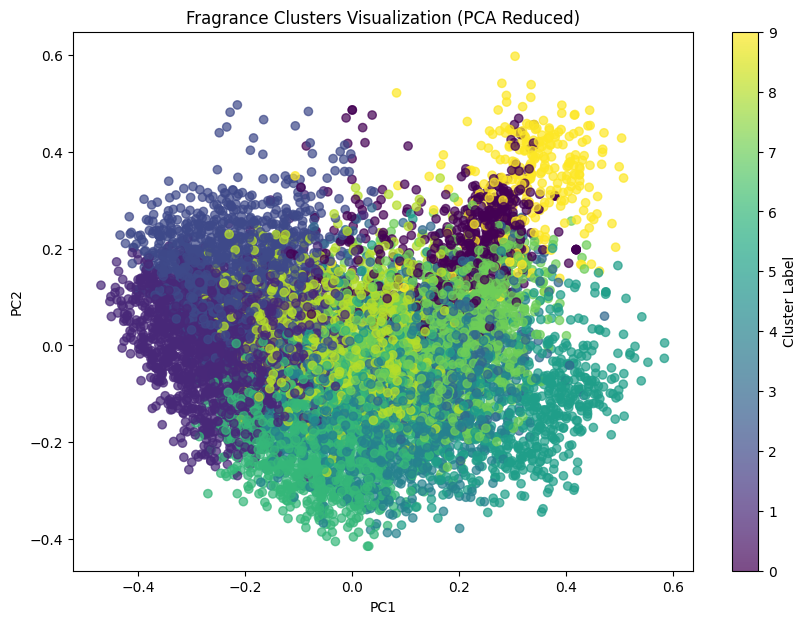

In [17]:
pca = PCA(n_components=2, random_state=42)
reduced_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Cluster Label')
plt.title('Fragrance Clusters Visualization (PCA Reduced)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [18]:
data['cluster'] = cluster_labels

In [19]:
pos_pairs = []
neg_pairs = []

cluster_map = {}
for i, c in enumerate(cluster_labels):
    cluster_map.setdefault(c, []).append(i)

for c, indices in cluster_map.items():
    if len(indices) > 1:
        # Generate pairs within the cluster
        for i in range(len(indices)):
            for j in range(i+1, len(indices)):
                pos_pairs.append((indices[i], indices[j]))

In [20]:
all_indices = list(range(len(data)))
for c, indices in cluster_map.items():
    other_indices = [idx for idx in all_indices if cluster_labels[idx] != c]
    neg_sample_size = min(len(indices), len(other_indices))
    neg_indices_sample = np.random.choice(other_indices, size=neg_sample_size, replace=False)
    pos_indices_sample = np.random.choice(indices, size=neg_sample_size, replace=True)

    for i1, i2 in zip(pos_indices_sample, neg_indices_sample):
        neg_pairs.append((i1, i2))

In [21]:
pairs = [(p[0], p[1], 1) for p in pos_pairs] + [(n[0], n[1], 0) for n in neg_pairs]
np.random.shuffle(pairs)

In [22]:
X1 = []
X2 = []
Y = []
for (i1, i2, label) in pairs:
    X1.append(embeddings[i1])
    X2.append(embeddings[i2])
    Y.append(label)

X1 = np.array(X1)
X2 = np.array(X2)
Y = np.array(Y)

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
print("X1 shape:", X1.shape, "X2 shape:", X2.shape, "Y shape:", Y.shape)

X1 shape: (5992020, 384) X2 shape: (5992020, 384) Y shape: (5992020,)


In [25]:
subset_size = min(len(Y), 500000) 
X1_sub = X1[:subset_size]
X2_sub = X2[:subset_size]
Y_sub = Y[:subset_size]

X1_temp, X1_test, X2_temp, X2_test, Y_temp, Y_test=train_test_split(X1_sub, X2_sub, Y_sub, test_size=0.2, random_state=42)


X1_train, X1_val, X2_train, X2_val, Y_train, Y_val = train_test_split(X1_temp, X2_temp, Y_temp, test_size=0.1, random_state=42)


print("Training set class distribution:", np.bincount(Y_train))
print("Validation set class distribution:", np.bincount(Y_val))
print("Test set class distribution:", np.bincount(Y_test))

Training set class distribution: [   623 359377]
Validation set class distribution: [   58 39942]
Test set class distribution: [  179 99821]


In [26]:
embedding_dim = embeddings.shape[1]

# Define inputs
input_1 = Input(shape=(embedding_dim,))
input_2 = Input(shape=(embedding_dim,))

In [27]:
dense = layers.Dense(128, activation='relu')
out_1 = dense(input_1)
out_2 = dense(input_2)

In [28]:
l1_distance = tf.abs(out_1 - out_2)
similarity_score = layers.Dense(1, activation='sigmoid')(l1_distance)

In [29]:
siamese_model = Model(inputs=[input_1, input_2], outputs=similarity_score)
siamese_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
siamese_model.summary(show_trainable=True)

Model: "model"
_____________________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  Trainable  
 input_1 (InputLayer)        [(None, 384)]                0         []                            Y          
                                                                                                             
 input_2 (InputLayer)        [(None, 384)]                0         []                            Y          
                                                                                                             
 dense (Dense)               (None, 128)                  49280     ['input_1[0][0]',             Y          
                                                                     'input_2[0][0]']                        
                                                                                                         

In [31]:
history = siamese_model.fit(
    [X1_train, X2_train],
    Y_train,
    batch_size=32,
    epochs=5,
    validation_data=([X1_val, X2_val], Y_val)
)

Epoch 1/5
11250/11250 [==============================] - 5s 442us/step - loss: 0.0218 - accuracy: 0.9982 - val_loss: 0.0129 - val_accuracy: 0.9985
Epoch 2/5
11250/11250 [==============================] - 5s 436us/step - loss: 0.0134 - accuracy: 0.9983 - val_loss: 0.0118 - val_accuracy: 0.9985
Epoch 3/5
11250/11250 [==============================] - 5s 434us/step - loss: 0.0117 - accuracy: 0.9983 - val_loss: 0.0115 - val_accuracy: 0.9985
Epoch 4/5
11250/11250 [==============================] - 5s 431us/step - loss: 0.0108 - accuracy: 0.9983 - val_loss: 0.0112 - val_accuracy: 0.9985
Epoch 5/5
11250/11250 [==============================] - 5s 430us/step - loss: 0.0097 - accuracy: 0.9983 - val_loss: 0.0109 - val_accuracy: 0.9986


In [32]:
val_preds_prob = siamese_model.predict([X1_val, X2_val])
val_preds = (val_preds_prob > 0.5).astype("int32").flatten()

1250/1250 [==============================] - 0s 279us/step


In [33]:
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report
import seaborn as sns

Confusion Matrix:


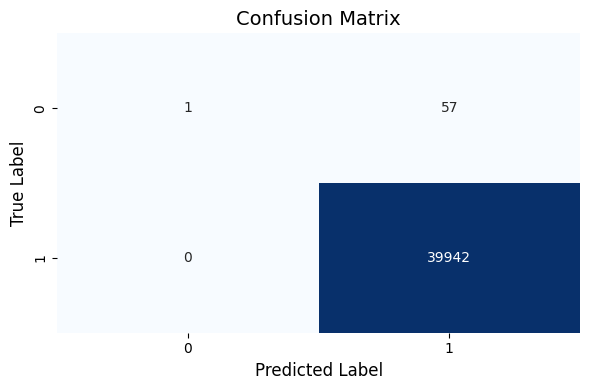

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.0172    0.0339        58
           1     0.9986    1.0000    0.9993     39942

    accuracy                         0.9986     40000
   macro avg     0.9993    0.5086    0.5166     40000
weighted avg     0.9986    0.9986    0.9979     40000



In [34]:
cm = confusion_matrix(Y_val, val_preds)
print("Confusion Matrix:")

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()


cr = classification_report(Y_val, val_preds, digits=4)
print("Classification Report:")
print(cr)

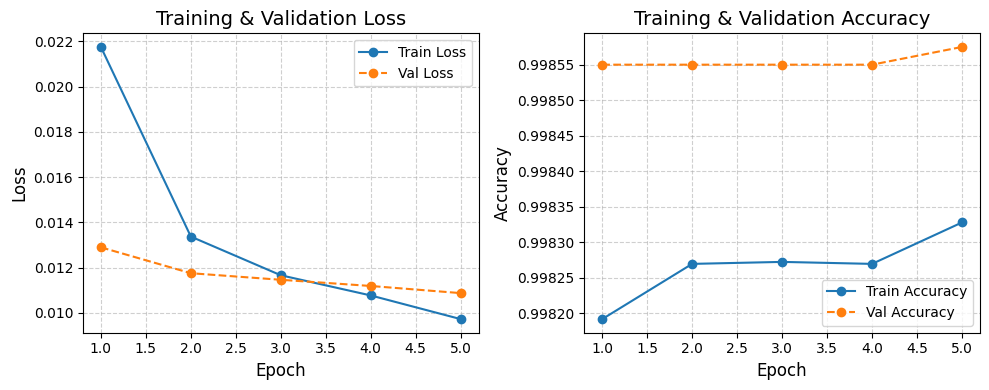

In [35]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, 'o-', label='Train Loss')
plt.plot(epochs, val_loss, 'o--', label='Val Loss')
plt.title('Training & Validation Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_acc, 'o-', label='Train Accuracy')
plt.plot(epochs, val_acc, 'o--', label='Val Accuracy')
plt.title('Training & Validation Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()

In [36]:
def enrich_single_note(note):
    lower_note = note.lower()
    if lower_note in note_enrichment:
        return note_enrichment[lower_note]
    else:
        return note

def recommend_fragrances_by_notes(notes_list, top_k=5, gender=None):
    enriched_notes = [enrich_single_note(n) for n in notes_list]
    query_text = " ".join(enriched_notes)
    query_embedding = model.encode([query_text])[0]
    if gender is not None:
        candidate_df = data[data['gender'].str.lower() == gender.lower()]
    else:
        candidate_df = data
    candidate_embeddings = embeddings[candidate_df.index]
    sims = cosine_similarity(query_embedding.reshape(1, -1), candidate_embeddings)[0]

    top_indices = sims.argsort()[::-1][:top_k]
    recommended_indices = candidate_df.iloc[top_indices].index
    return data.loc[recommended_indices, 'title'].tolist()

In [56]:
user_notes_input = input("Please enter notes separated by commas (e.g., Bergamot,Jasmine,Patchouli): ")
notes_query = [note.strip() for note in user_notes_input.split(',') if note.strip()]
user_gender_input = input("Please enter desired gender filter (Men/Women/Unisex) or press enter to skip: ").strip()

if user_gender_input.lower() not in ["men", "women", "unisex", ""]:
    print("Invalid gender input. Proceeding without gender filter.")
    user_gender_input = None
elif user_gender_input == "":
    user_gender_input = None
recommendations = recommend_fragrances_by_notes(notes_query, top_k=3, gender=user_gender_input)
print("Recommended Fragrances:", recommendations)

Please enter notes separated by commas (e.g., Bergamot,Jasmine,Patchouli):  Strawberry
Please enter desired gender filter (Men/Women/Unisex) or press enter to skip:  Women


Recommended Fragrances: ['Strawberry Perfume Oil The Body Shop for women', 'Strawberry Party Poesie for women', 'Sunny Strawberry & Guava Avon for women']


In [52]:
from tensorflow.keras.utils import plot_model

In [54]:
plot_model(siamese_model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [51]:
import os
os.system("dot -V")

dot - graphviz version 12.2.1 (20241206.2353)


0